# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [46]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil



### Sample Size Calculation

In [109]:
effect_size = sms.proportion_effectsize(0.06, 0.09)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          
print(required_n)

1199


### Collecting and preparing the data

In [110]:
df = pd.read_csv('tiktok_data.csv')
df.head()

,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


- user_id - The user ID of each session
- timestamp - Timestamp for the session
- group - Which group the user was assigned to for that session {control, treatment}
- landing_page - Which design each user saw on that session {old_page, new_page}
- converted - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

In [112]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,136002,1816
treatment,1855,136108


#### Before we go ahead and sample the data to get our subset, let’s make sure there are no users that have been sampled multiple times.

In [113]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(multi_users)

3453


#### There are 3894 users that appear more than once. Since the number is pretty low, we’ll go ahead and remove them from the DataFrame to avoid sampling the same users twice.

In [114]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(df.shape[0])

268875


#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [115]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

In [116]:
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,button,liked
0,644761,2017-01-20 5:19:16,control,heart,0
1,856804,2017-01-02 23:19:00,control,heart,0
2,728826,2017-01-03 4:16:37,control,heart,0
3,865441,2017-01-19 3:59:57,control,heart,0
4,796969,2017-01-05 4:08:26,control,heart,0
...,...,...,...,...,...
2393,647852,2017-01-16 4:47:04,treatment,star,0
2394,814529,2017-01-15 1:01:37,treatment,star,1
2395,924465,2017-01-13 8:37:42,treatment,star,0
2396,660778,2017-01-12 1:55:29,treatment,star,0


In [117]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2398 entries, 0 to 2397
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    2398 non-null   int64 
 1   timestamp  2398 non-null   object
 2   group      2398 non-null   object
 3   button     2398 non-null   object
 4   liked      2398 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 93.8+ KB


In [118]:
ab_test['group'].value_counts()


control      1199
treatment    1199
Name: group, dtype: int64

### Analysis Visualization

In [119]:
conversion_rates = ab_test.groupby('group')['liked']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.109,0.312,0.009
treatment,0.118,0.323,0.009


#### Judging by the stats above, it does look like our two designs performed very similarly, with our new design performing slightly better, approx. 12.3% vs. 12.6% conversion rate.

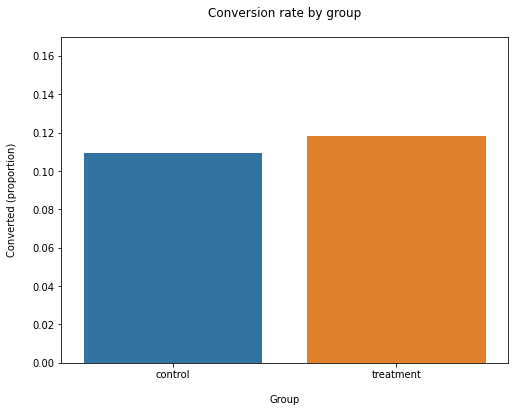

In [120]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['liked'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

### Testing for Stat Sig

#### Python makes all the calculations very easy. We can use the statsmodels.stats.proportion module to get the p-value and confidence intervals

In [121]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['liked']
treatment_results = ab_test[ab_test['group'] == 'treatment']['liked']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

In [122]:
z_stat, pval = proportions_ztest(successes, nobs=nobs) #Test for proportions based on normal ztest
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05) #confidence interval for a binomial proportion


In [123]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.71
p-value: 0.479
ci 95% for control group: [0.092, 0.127]
ci 95% for treatment group: [0.100, 0.137]


#### Were the results signficant? What would you advise the engineering team to do moving forward?

1199
